# Bitcoin Price Prediction using RNN

We are building a Recurrent Neural Network (RNN) model to predict Bitcoin prices using historical price data. The model takes a sequence of 10 days of closing prices to predict the next day's price, essentially learning patterns in Bitcoin's price movements over time. This is a simplified version of time series forecasting and can be extended to more complex models and longer sequences for more accurate predictions.

## Import libraries

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## Data Preparation

In [9]:
# Data preprocessing
def load_and_preprocess_data():
    """Load and preprocess the Bitcoin price data"""
    # Read CSV file
    df = pd.read_csv('CRYPTOCURRENCY_US_COINDESK_BTCUSD.csv')
    
    # Convert Close prices from string to float
    df['Close'] = df['Close'].str.replace(',', '').astype(float)
    
    # Sort by date to ensure chronological order (oldest to newest)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    return df['Close'].values

# Prepare sequences for RNN
def prepare_sequences(data, sequence_length=7):
    """Prepare sequences for RNN"""
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler

# Create BitCoinDataset
class BitcoinDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Build model

In [10]:
# RNN Model
class BitcoinRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(BitcoinRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


## Training function

In [11]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return train_losses

Epoch [10/50], Loss: 0.0016
Epoch [20/50], Loss: 0.0010
Epoch [30/50], Loss: 0.0010
Epoch [40/50], Loss: 0.0007
Epoch [50/50], Loss: 0.0008

Model Performance Metrics:
MSE: 5760117.00
RMSE: 2400.02
MAE: 2184.00


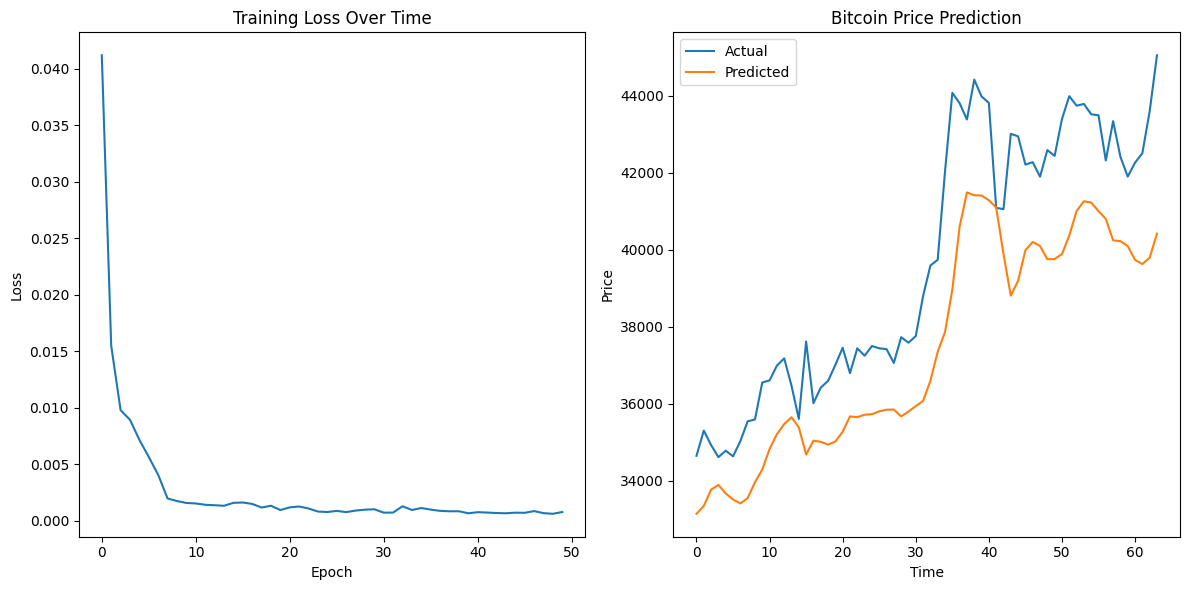

In [13]:
# Load and preprocess data
close_prices = load_and_preprocess_data()

# Parameters
sequence_length = 10
train_size = int(len(close_prices) * 0.8)
batch_size = 32
num_epochs = 50

# Prepare sequences
X, y, scaler = prepare_sequences(close_prices, sequence_length)

# Split data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create datasets and dataloaders
train_dataset = BitcoinDataset(X_train, y_train)
test_dataset = BitcoinDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model, loss function, and optimizer
model = BitcoinRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predictions.extend(outputs.numpy())
        actuals.extend(y_batch.numpy())

# Inverse transform predictions and actuals
predictions = scaler.inverse_transform(np.array(predictions))
actuals = scaler.inverse_transform(np.array(actuals))

# Calculate metrics
mse = np.mean((predictions - actuals) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - actuals))

print(f'\nModel Performance Metrics:')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Plot results
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot predictions vs actuals
plt.subplot(1, 2, 2)
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()
